In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import null_space
from IPython.display import clear_output
import random

import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [2]:
X = pd.read_csv("../Data/data.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()
y = pd.read_csv("../Data/labels.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()

In [3]:
X_proto = X[1:101, 1:201]
y_proto = y[1:101]

In [5]:
class PCAObject:
    def __init__(self, PCs, X, label):
        assert len(PCs) == X.shape[0], "Need all the principal components!"
        self.pcs = PCs
        self.X = StandardScaler().fit_transform(X)
        self.cov = np.cov(self.X.T)
        self.label = label
        self.pev, self.cev, self.ev = None, None, None
        self.nonZeroLoads = None
    
    def calcExpVar(self):
        tot_var = np.sum(np.diag(self.cov))
        self.ev = np.diag(self.pcs @ np.cov(self.X.T) @ self.pcs.T)/np.linalg.norm(self.pcs, axis = 1)**2
        self.pev = [ev/tot_var for ev in self.ev]
        self.cev = np.cumsum(np.flip(np.sort(self.pev)))
        
    def calcNonZeroLoads(self):
        self.nonZeroLoads = [np.count_nonzero(pc) for pc in self.pcs]
        
    def plotNonZeroLoadtoPEV(self):
        self.calcExpVar()
        self.calcNonZeroLoads()
            
        plt.plot(self.nonZeroLoads, self.pev, label=self.label)
        plt.xlabel('Number of non-zero loadings')
        plt.xscale('log')
        plt.ylabel('Percentage of explained variance (PEV)')
        plt.legend()
        plt.title('Percentage of explained variance (PEV) vs non-zero loadings')
        
    def plotCEV(self):
        self.calcExpVar()
        x = np.arange(len(self.pcs))
        
        plt.plot(x, np.sort(self.cev), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Cumulative explained variance (CEV)')
        plt.legend()
        plt.title('Cumulative explained variance (CEV)')

In [6]:
def reg_PCA(X, k = "all"): 
    """
    function takes an n x p feature matrix
    returns two arrays:
    - array with percentage of explained variance in first k principal directions (k_comp x 1)
    - array with principal directions (k_comp x p)
    """
    X = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    pca = PCA(n_components = k)
    pca.fit(X)
    PEVs = pca.explained_variance_ratio_
    prin_comp = pca.components_
    EVs = pca.explained_variance_
    
    return PEVs, prin_comp, EVs

In [7]:
def threshold_PCA(X, thresh = 1e-1, k = "all"):
    """
    function takes
    - X: n x p feature matrix
    - thresh: float representing this non-zero cutoff
    - k: integer for number of principal directions wanted
    returns one array:
    - array with principal components in its columns (k x p)
    """
    if k == "all": k = min(X.shape[0],X.shape[1])

    pcs = reg_PCA(X)[1]
    pcs = (np.abs(pcs) >= thresh).astype(int) * pcs
    
    return pcs[:k]

In [8]:
def nonZeroLoad_PCA(X,j, k = "max"):
    """
    function takes
    - X: n x p feature matrix
    - j: integer for number of non-zero loadings,
    - k: integer for number of principal directions wanted
    returns three arrays:
    - array with percentages of explained variance in first k principal directions (k x 1)
    - array with principal directions (k x p)
    - array with explained variances
    """   
    X_scaled = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    
    PCA_PEV, PCA_PC, PCA_EV = reg_PCA(X,min(X.shape[0],X.shape[1]))
    
    total_var = sum(PCA_EV)
    
    thresh_PCA_PC = np.empty((0,PCA_PC.shape[1]))
    thresh_PCA_PEV = []
    thresh_PCA_EV = []
    
    PCA_PC_sorted = np.sort(np.absolute(PCA_PC), axis = 1)
    for m in range(k):
        thresh = PCA_PC_sorted[m][-j]
        thresh_PC = (np.absolute(PCA_PC[m]) >= thresh).astype(int)*PCA_PC[m]
        thresh_PCA_PC = np.vstack((thresh_PCA_PC, thresh_PC))
    
    return thresh_PCA_PC

In [9]:
def SimpTrans(r, s, k, X_scaled):
    """
    function takes
    - Two directions r and s to transform
    - An integer k that restricts the possible directions
    - The scaled data matrix X
    returns two vectors and three floats
    - Two new directions r and s
    - Two floats representing the variances explained by the new directions r and s
    - One float representing the covariance of the new directions r and s
    """
    # Calculate the covariance matrix for the two directions
    cov = np.vstack((r,s)) @ np.cov(X_scaled.T) @ np.vstack((r,s)).T
    v_old_r, v_old_s, v_old_rs = cov[0,0], cov[1,1], cov[0,1]
    
    # Get a list of all possible betas
    poss_beta1 = [i/2**k for i in range(-2**k, 2**k+1, 1)]
    poss_beta2 = [2**k/i for i in range(-2**k, 2**k+1, 1) if i != 0]
    poss_beta = np.sort(list(set(poss_beta1 + poss_beta2)))
    
    # Calculate the norms of the two directions
    l2_r, l2_s = np.linalg.norm(r)**2, np.linalg.norm(s)**2
    
    # Find the beta that maximizes the variance in the normalized
    # direction of the first new principal component
    v_r, v_s, v_rs = cov[0,0], cov[1,1], cov[0,1]
    a = l2_s*v_rs
    b = np.sqrt(l2_r*l2_s)*(v_r - v_s)
    c = l2_r*v_rs
    discr = b**2 - 4*a*c
    beta_star = (-b+np.sqrt(discr))/(2*a)
    
    # Select beta from possible values that's closest to the optimal value
    beta_star = min(list(poss_beta), 
                    key = lambda x:abs(x-beta_star))
    
    # Calculate the two new directions
    if abs(beta_star) <= 1:
        r_new = 2**k*r + 2**k*beta_star*s
        s_new = 2**k*beta_star*l2_s*r - 2**k*l2_r*s
    else:
        r_new = 2**k*r/beta_star + 2**k*s
        s_new = 2**k*l2_s*r - 2**k*l2_r*s/beta_star
    
    # Calculate variances and covariance of the new directions
    P = np.array([[1, l2_s*beta_star],[beta_star, -l2_r]])
    cov_new = P.T @ cov @ P
    v_r, v_s, v_rs = cov_new[0,0], cov_new[1,1], cov_new[0,1]
    
    return r_new, s_new, v_r, v_s, v_rs

In [10]:
def pcPairFinder(cov, cache):
    """
    function takes
    - A covariance matrix
    - A cache containing the indices of excluded pcs
    returns two integers:
    - i_r: the index of the first principal component
    - i_s: the index of the second principal component
    """
    # Turn covariance matrix into a sparse lower triangular matrix
    grid = np.tril(cov, k = -1)
    vrs = np.diag(cov)
    # Flatten the grid and sort from largest cov to smallest cov
    srt = np.sort(np.ravel(grid), kind = 'heapsort')
    lst = list(np.flip(np.trim_zeros(srt)))
    mask = False
    
    # Find the pair of pcs that are not already in the cache and hav
    # the highest covariance in the grid
    while not np.any(mask):
        covar = lst.pop(0)
        index = np.argwhere(grid == covar)
        mask = np.ravel(np.invert(np.any(np.isin(index, cache), axis = 1, keepdims = True)))

    # Unpack the indices make sure that the variance of r is larger than the variance of s
    index = index[mask,:][0]
    i_r = index[np.argmax([vrs[i] for i in index])]
    i_s = index[np.argmin([vrs[i] for i in index])]
    return i_r, i_s

In [11]:
def simple_PCA(X, k, iters = 1):
    """
    function takes
    - An unscaled data matrix X
    - An integer k that restricts the possible directions
    - An integer indicating the number of iterations
    returns one array:
    - array with principal components in its columns (k x p)
    """
    # Retrieve the principal components and their covariance matrix
    n_obs, n_feats = X.shape
    q = np.identity(n_obs)
    for _ in range(n_feats//n_obs):
        q = np.hstack((q,np.identity(n_obs)))
    pcs = q[:n_obs,:n_feats]
    
    cov = np.cov(X.T)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Setup up globals for loop
    cov_pc = pcs @ cov @ pcs.T
    cache = []
    
    for _ in range(iters):
        while len(cache) <= len(pcs) - 2:
            clear_output(wait = True)
            print("Working on principal component ", len(cache) + 2,"/",len(pcs))
            
            # Find set of principal components to transform
            i_r, i_s = pcPairFinder(cov_pc, cache)
            r, s = pcs[i_r], pcs[i_s]
            cache += [i_r, i_s]
            
            # Transform the pair of components
            print("Determining new directions...")
            r_new, s_new, v_r, v_s, v_rs = SimpTrans(r, s, k, X_scaled)

            # Update the principal components
            pcs[i_r] = r_new
            pcs[i_s] = s_new
            
            # Update the grid matrix
            cov_pc[i_s, i_r], cov_pc[i_r, i_s] = v_rs, v_rs
    
    return pcs

In [12]:
def lass_pen(x, gamma):
    '''
    regularization penalty function for scotlass
    
    function takes 
    - x: float
    - gamma: float
    
    function returns 
    - penalty value: float
    '''
    return (0.5 * x) * (1 + np.tanh(gamma*x))

def lass_obj(sigma, v, reg_param, gamma):
    '''
    objective function for scotlass
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - objective function value at v (p x 1 vector)
    '''
    varimax = (0.5*v.T) @ sigma @ v
    argpen = v.T @ np.tanh(1000*v)-reg_param
    penalty = gamma * lass_pen(argpen, gamma)
    return np.array(varimax - penalty).flatten()

def lass_grad(sigma, v, reg_param, gamma):
    '''
    gradient of objective function for scotlass
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - gradient of objective function at v
    '''
    # Setup of parameters
    mu = 1000
    
    # Calculate floats
    y = (v.T @ np.tanh(gamma*v))-reg_param
    q = 1 + np.tanh(gamma*y) + gamma*np.cosh(gamma*y)**(-2)*y
    
    # Calculate vectors
    z = np.tanh(gamma*v) + gamma * (np.diag(np.ravel(np.cosh(gamma*v)**(-2))) @ v)
    
    return (sigma @ v) - 0.5*mu*q*z 

In [13]:
def scotlassGradAsc(sigma, V, reg_param = 'default', x0 = 'default', 
                    alpha = '1/t', max_iter = 10000, crit = 1e-1000):
    '''
    function takes
    - sigma: p x p covariance matrix
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - v: first sparse principal direction (array of length p)
    - variance of data along v
    '''
    # Configure the parameters
    iters, delta, gamma = 1, 1, 1000
    num_obs, num_feat = sigma.shape
    
    # Configure the regularization parameter
    reg_error = '''
    The regularization parameter needs to be smaller than 
    the square root of the number of features in the dataset.
    '''
    if reg_param == 'default': reg_param = np.sqrt(num_feat)
    else: assert reg_param <= np.sqrt(num_feat), reg_error
    
    # Setup gradient step size
    if alpha == '1/t': alpha = lambda t: 10**-6
    else: alpha = lambda t: 1/np.sqrt(t)
    
    # Initialize the algorithm
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Projected gradient descent
    # Stopping criteria:
    # (1) Maximum iterations reached
    # (2) Change in objective function negligible
    while iters < max_iter and delta > crit:
        
        # Update the vector
        v_new = v + alpha(iters)*lass_grad(sigma, v, reg_param, gamma)
        
        # Project loading vector back onto feasible set 
        # (vectors of l2 norm of 1 that are orthogonal to all other pcs)
        v_proj = V @ v_new
        v_proj = v_proj/(np.linalg.norm(v_proj))
        
        # Use the projected loading vector to retrieve the value of the
        # objective function
        old_obj = lass_obj(sigma, v, reg_param, gamma)[0]
        updated_obj = lass_obj(sigma, v_proj, reg_param, gamma)[0]

        # Calculate the difference in value of the objective function
        delta = [updated_obj - old_obj][0]
        
        # Update vector and number of iterations
        v, iters = v_proj, iters + 1
    
    # return loadings array v
    return v

In [14]:
def SCoTLASS(X, reg_param, x0 = 'default', alpha = '1/t',
             max_iter = 10000, crit = 1e-1000):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = sigma.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = X.shape)
    
    # Initialize projection vector V
    V = np.identity(num_feat)
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = scotlassGradAsc(sigma, V, reg_param, x0, alpha, max_iter, crit)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
    return pcs

For $B\in \mathbb{R}^{p\times m}$:
$$
Varimax(B) = \frac{1}{p^2}\sum_{k=1}^m\left[\underbrace{m\sum_{j=1}^p b_{jk}^4}_{P} - \underbrace{\left(\sum_{j=1}^p b_{jk}^2\right)^2}_{Q}\right]
$$

In [15]:
def varimax(B):
    p, m = B[None,:].shape
    P = m*np.sum(np.power(B, 4), axis = 0)
    Q = np.power(np.sum(np.power(B, 2), axis = 0), 2)
    return 1/p**2 * np.sum(P - Q)    

In [27]:
def SCoT(X, reg_param, x0 = 'default'):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = sigma.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = X.shape)

    # Configure objective function
    obj_fun = lambda x, sigma, reg_param: -(x.T @ sigma @ x + reg_param * varimax(x))
    
    # Initial vector for gradient descent
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Initial orthogonal complement to previous pcs
    V = np.identity(num_feat)
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = minimize(obj_fun, x0, args = (sigma, reg_param)).x
        pc = (V @ pc)/np.linalg.norm(V @ pc)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
        x0 = x0/np.linalg.norm(x0)
        
    return pcs

In [30]:
reg_thresh = PCAObject(threshold_PCA(X_proto), X_proto, "Thresh")
reg_reg = PCAObject(reg_PCA(X_proto)[1], X_proto, "Regular")
reg_scot = PCAObject(SCoT(X_proto, 10), X_proto, "SCoT")
reg_scotlass_1 = PCAObject(SCoTLASS(X_proto,1), X_proto, "SCoTLASS")
reg_scotlass_14 = PCAObject(SCoTLASS(X_proto,14), X_proto, "SCoTLASS")

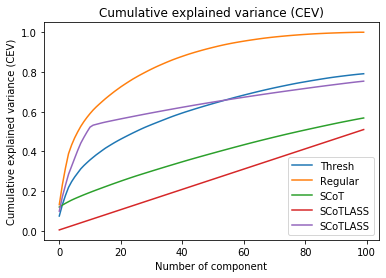

In [31]:
reg_thresh.plotCEV()
reg_reg.plotCEV()
reg_scot.plotCEV()
reg_scotlass_1.plotCEV()
reg_scotlass_14.plotCEV()

Text(0.5, 1.0, ' ')

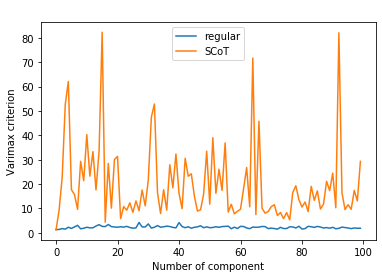

In [43]:
x = np.arange(len(reg_reg.pcs))

vm_reg = np.apply_along_axis(varimax, axis = 1, arr = reg_reg.pcs)
vm_scot = np.apply_along_axis(varimax, axis = 1, arr = reg_scot.pcs)

plt.plot(x, vm_reg, label = "regular")
plt.plot(x, vm_scot, label = "SCoT")
plt.xlabel('Number of component')
plt.ylabel('Varimax criterion')
plt.legend()
plt.title(' ')

(array([ 3.,  8., 16., 17., 40., 31., 27., 28., 19., 11.]),
 array([-0.14811851, -0.1173834 , -0.08664829, -0.05591318, -0.02517806,
         0.00555705,  0.03629216,  0.06702727,  0.09776238,  0.12849749,
         0.1592326 ]),
 <a list of 10 Patch objects>)

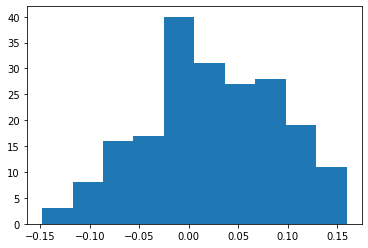

In [49]:
plt.hist(reg_reg.pcs[0])

In [60]:
np.sum(np.apply_along_axis(varimax, axis = 1, arr = reg_scotlass_14.pcs))

236.47654778870128

In [62]:
np.sum(np.apply_along_axis(varimax, axis = 1, arr = reg_scot.pcs))

1985.7487324267101

In [64]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [67]:
gini(reg_scot.ev)

0.3164149137082945

In [68]:
gini(reg_reg.ev)

0.6820711002424675

In [69]:
gini(reg_scotlass_1.ev)

3.86288207640199e-06

In [70]:
gini(reg_scotlass_14.ev)

0.6386998410654262

In [71]:
gini(reg_thresh.ev)

0.4978830966335464